# Data preprocessing notebook

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import scipy.stats as stats
import requests 
import math
import numpy as np

from preprocessing_helper import get_values_occurrences, plot_gpt_answers_pie_charts

## Table of Contents

* [Importing the data](#importation)
    * [First visualization](#visualization)
* [Preprocessing the movies dataframe](#movie_preprocessing)
    * [Movie release date](#movie_release)
    * [Movie box office revenue](#box_office)
    * [Movie runtime](#runtime)
    * [Movie languages](#language)
    * [Movie countries](#countries)
    * [Movie genres](#movie_genre)    
* [Preprocessing the characters dataframe](#char_preprocessing)
    * [Movie release date](#rel_date)
    * [Actor date of birth](#birth)
    * [Actor gender](#char_gender)
    * [Actor height](#height)
    * [Actor age at movie release](#age_release)
    * [Actor persona](#persona)
* [Preprocessing the summaries dataframe](#summary)
* [IMDB ratings preprocessing](#IMDB)
    * [Loading the ratings](#load_rate)
    * [Preprocessing the ratings](#Preprocessing_rate)
    * [Average rating](#average_rate)
    * [Number of votes](#vote)
* [Removing unnecessary columns](#remove_col)
* [Dropping Duplicates](#drop_dup)
* [Saving](#Saving)

### Importing the data <a class="anchor" id="importation"></a>


In [2]:
path = './Data/MovieSummaries/'
path_lda = './Data/LDA/ALL/'

movies = pd.read_csv(path+'movie.metadata.tsv', delimiter='\t',
                             names = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name',
                                      'Movie release date', 'Movie box office revenue', 'Movie runtime',
                                      'Movie languages', 'Movie countries', 'Movie genres'])


characters = pd.read_table(path+'character.metadata.tsv',
                                  names = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date',
                                           'Character name', 'Actor date of birth', 'Actor gender',
                                           'Actor height (in meters)', 'Actor ethnicity (Freebase ID)',
                                           'Actor name','Actor age at movie release',
                                           'Freebase character/actor map ID', 'Freebase character ID',
                                           'Freebase actor ID'])

summaries = pd.read_csv(path+'plot_summaries.txt', sep="\t", names=['Wikipedia movie ID', 'Summary'])


movies['Movie languages'] = movies['Movie languages'].apply(lambda language : json.loads(language))
movies['Movie genres'] = movies['Movie genres'].apply(lambda genre : json.loads(genre))
movies['Movie countries'] = movies['Movie countries'].apply(lambda countries : json.loads(countries))

#### First visualization <a class="anchor" id="visualization"></a>

Let's have a first look at what the data looks like:

In [3]:
movies.head(2)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp..."


In [4]:
characters.head(2)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


In [5]:
summaries.head(2)

,Wikipedia movie ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...


We first want to preprocess the data in order to remove any outliers or mistakes. For this, let's have a look at descriptive statistics for interpretable columns (like movie runtime or release date, in contrast to movie name) and figure out if there are any issues and, if so, which issues. Note that this is not necessary for the `summaries` dataframe, since we have no way of finding mistakes without reading the text.

### Preprocessing the movies dataframe <a class="anchor" id="movie_preprocessing"></a>


In [6]:
movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'}


In the movies dataframe, the interpretable columns are `Movie release date`, `Movie box office revenue` and `Movie runtime`. We can also have a look at all distinct genres, countries and languages to see if anything is wrong. Here is a (non-exhaustive) list of things we can do:
- check for outliers (and filter them if necessary)
- check for missing values
- process the values to be consistent
- create a list of distinct genres/languages/countries
- normalize the values (min-max or $\frac{x_i-\mu}{\sigma}$)

#### Movie release date <a class="anchor" id="movie_release"></a>

First, we notice that the release date formats are inconsistent. Some are of the form `year` and others, `yyyy-mm-dd`. In order to compare these, we add a new column containing only the year.

In [7]:
def get_year(date):
    return int(str(date).split('-')[0])

movies['Movie year'] = movies['Movie release date'].apply(lambda d: get_year(d) if type(d)==str else d)
movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",2000.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",1988.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...",1987.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'},1983.0


`Movie year` contains the year of the movie release date or is NaN if there was no value to begin with. First, let's check (sanity check) that there are still as many missing values for the newly created column as for the previous release date column. We also print the percentage of missing values overall.

In [8]:
assert movies['Movie year'].isna().sum() == movies['Movie release date'].isna().sum()

In [9]:
def get_missing_values_percentage(dataframe, column):
    return dataframe[column].isna().sum()/len(dataframe[column])*100

In [10]:
print(f"There is {get_missing_values_percentage(movies, 'Movie year'):.2f}% of data missing in total.")

There is 8.44% of data missing in total.


Now, we can explore the release year statistics and find outliers:

In [11]:
movies['Movie year'].describe()

count    74839.000000
mean      1977.476530
std         29.101536
min       1010.000000
25%       1956.000000
50%       1985.000000
75%       2004.000000
max       2016.000000
Name: Movie year, dtype: float64

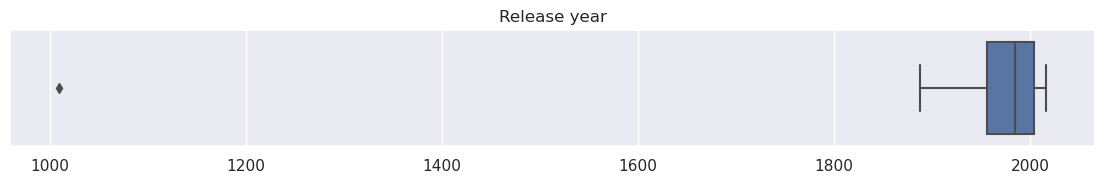

In [12]:
def plot_boxplot(dataframe, column, title):
    sns.set(rc={'figure.figsize':(14, 1.5)})
    sns.boxplot(dataframe[column], orient="h")
    plt.yticks([])
    plt.title(title)
    sns.reset_defaults()
    plt.show()
    
plot_boxplot(movies, 'Movie year', 'Release year')

Clearly, there is an outlier. A movie supposedly came out around 1000 (1010 according to the statistics above). This doesn't make any sense, so let's filter it out. note than we keep the missing values because since we alter the whole dataframe, we may get rid of too much information if, for each column, we remove those containing a nan.

In [13]:
movies = movies[(movies['Movie year']>1010) | (movies['Movie year'].isna()==1)]

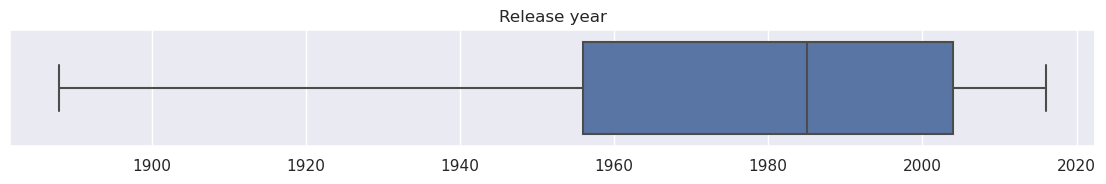

count    74838.000000
mean      1977.489457
std         28.886039
min       1888.000000
25%       1956.000000
50%       1985.000000
75%       2004.000000
max       2016.000000
Name: Movie year, dtype: float64

In [14]:
plot_boxplot(movies, 'Movie year', 'Release year')
movies['Movie year'].describe()

Now, the distribution seems to make sense, with the first movies in 1888 and a right-skewed distribution (there are more movies being produced now than in the 19th century (or early 20th)). However, for our analysis, we are just interested in keeping movies more recent that 1900, so let's filter the other ones out:

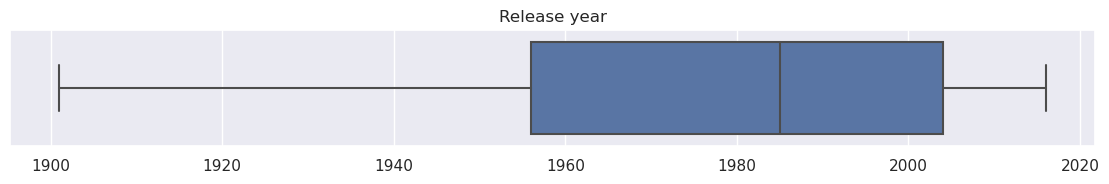

In [15]:
movies = movies[(movies['Movie year']>1900) | (movies['Movie year'].isna()==1)]
plot_boxplot(movies, 'Movie year', 'Release year')

#### Movie box office revenue <a class="anchor" id="box_office"></a>

In [16]:
movies['Movie box office revenue'].describe()

count    8.399000e+03
mean     4.800359e+07
std      1.121868e+08
min      1.000000e+04
25%      2.083876e+06
50%      1.063969e+07
75%      4.074810e+07
max      2.782275e+09
Name: Movie box office revenue, dtype: float64

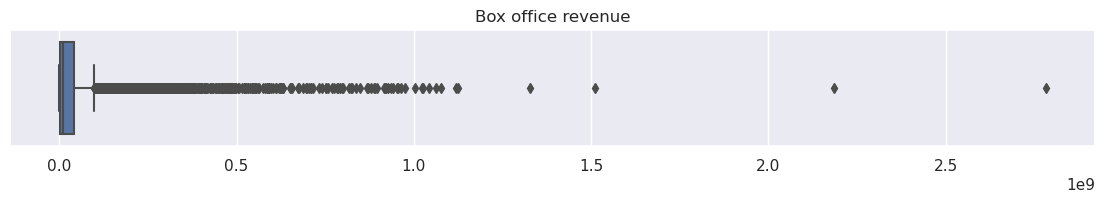

In [17]:
plot_boxplot(movies, 'Movie box office revenue', 'Box office revenue')

There seem to be many outliers, but this makes sense for box office revenue. Instead, let's focus on seeing how many values are missing.

In [18]:
print(f"There is {get_missing_values_percentage(movies, 'Movie box office revenue'):.2f}% of data missing.")

There is 89.70% of data missing.


89% of missing data is quite a lot. This is why we will later on, in order to not just rely on the 11% of data with box office revenue data, add another database containing ratings in order to analyze the success of a movie. But first, let's see how this missing data evolves over time.

In [19]:
def plot_missing_values(df, str_col):
    df['missing'] = pd.isnull(df[str_col])*100 #to convert to percentage
    plt.title(f'Percentage of missing {str_col.lower()} data per year')
    sns.lineplot(x = "Movie year", y = 'missing', data = df, errorbar = None)
    plt.ylabel(f"Percentage of missing {str_col.lower()} [%]")
    plt.show()
    df.drop(columns='missing', inplace=True)

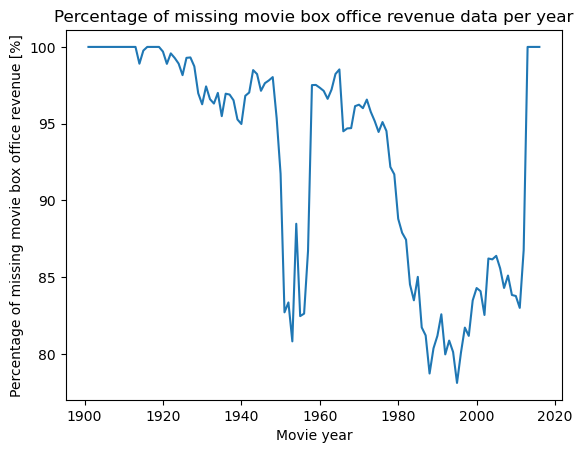

In [20]:
plot_missing_values(movies, 'Movie box office revenue')

As is to be expected, there is almost 100% of missing data until about 1930. Then, we have more data (only roughly 80% missing) in the 1950s and 1980s to 2010s. However, 80% of missing data is still a lot, which motivates our choice to add a dataset containing ratings in order to have another measure of success. This is done further down in this notebook.

#### Movie runtime <a class="anchor" id="runtime"></a>

Let's start by having a look at the distribution and how much data is missing.

In [21]:
movies['Movie runtime'].describe()

count    6.119800e+04
mean     1.119839e+02
std      4.363380e+03
min      5.000000e-02
25%      8.100000e+01
50%      9.300000e+01
75%      1.060000e+02
max      1.079281e+06
Name: Movie runtime, dtype: float64

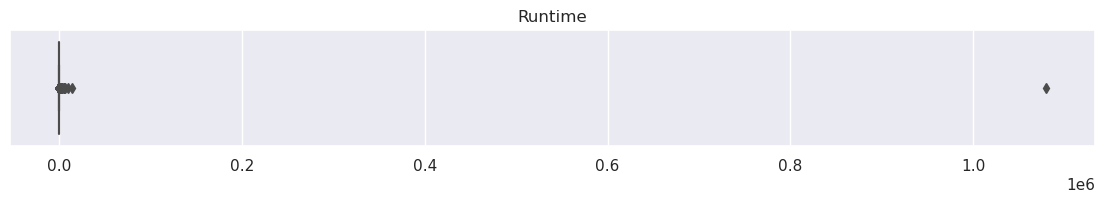

In [22]:
plot_boxplot(movies, 'Movie runtime', 'Runtime')

There is a clear outlier, a movie seems to be about 1079281 minutes long, which is about 2 years. This obviously makes no sense. We find the longest movies as follows:

In [23]:
movies.sort_values(by = 'Movie runtime', ascending=False).head(5)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie year
12804,10815585,/m/02qqy23,Zero Tolerance,1995,NaN,1079281.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/0lsxr': 'Crime F...",1995.0
62962,32441022,/m/0gyr803,Modern Times Forever,NaN,NaN,14400.0,{},{},{'/m/0jtdp': 'Documentary'},NaN
71100,25345684,/m/09gqhh3,Cinématon,2011,NaN,9360.0,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/0424mc': 'Experimental film', '/m/0jtdp':...",2011.0
21733,14545195,/m/03qcghh,Matrjoschka,2006-04-23,NaN,5700.0,{},{'/m/0345h': 'Germany'},"{'/m/0219x_': 'Indie', '/m/0jtdp': 'Documentary'}",2006.0
46666,884435,/m/03lmv2,The Cure for Insomnia,1987-01-31,NaN,5220.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/02n4lw': 'Art film'},1987.0


After some manual research and surprisingly given their length, the other movies seem correct. However, "Zero tolerance" is a mistake, so we filter it out. Note that we also remove movies that have a runtime equal to 0, as that does not make sense.

In [24]:
runtime_in_range = (movies['Movie runtime'] <= 15000) & (movies['Movie runtime'] > 0)
movies = movies[runtime_in_range | (movies['Movie runtime'].isna()==1)]

Next, let's look at how much data is missing. 25% of data is a lot, but as we probably will not use it for our project, it does not matter so much.

24.96% of data is missing


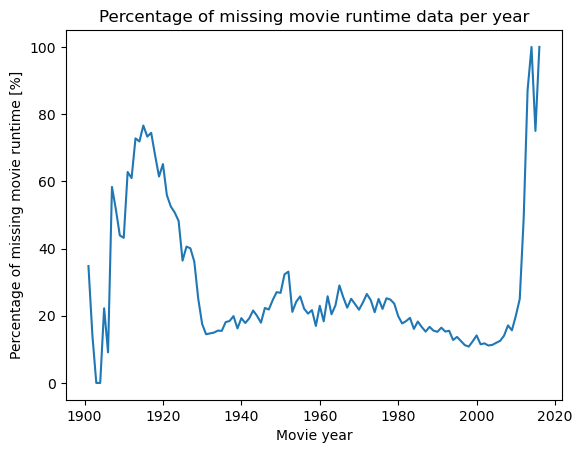

In [25]:
print(f"{get_missing_values_percentage(movies, 'Movie runtime'):.2f}% of data is missing")
plot_missing_values(movies, 'Movie runtime')

#### Movie languages  <a class="anchor" id="language"></a>


Movie languages, countries and genres are all dictionaries with freebase IDs as keys and strings (understandable for us) as values. To find "outliers" or abnormalities, we will iterate over the dataframe and make a dictionary mapping the strings (which should be unique also) to their number of occurrences. Then, we can check the least common languages (and the same for countries and genres) to see if they make sense (or if there is a typo or so for example). We use `get_values_occurrences`, a function defined in `preprocessing_helper` to do this.

In [26]:
languages_occurrences = get_values_occurrences(movies, 'Movie languages')
languages_sorted = sorted(languages_occurrences.items(), key=lambda x:x[1], reverse=False)
languages_sorted[0:5]

[('aceh language', 1),
 ('chhattisgarhi language', 1),
 ('sunda language', 1),
 ('picard language', 1),
 ('pawnee language', 1)]

While the least common languages don't look like typos, we do notice that for example, we did notice there is one occurence of "Deutsch", which should clearly belong to the 2258 movies with "German Language". The same goes for "Italian" and "Japan". However, we probably will not consider languages a lot in our project and there do not seem to be many such "mistakes", so we leave this as it is. Note that, as proof, we printed there occurrences below.

In [27]:
languages_sorted[23], languages_sorted[30], languages_sorted[40]

(('deutsch', 1), ('italian', 2), ('japan', 2))

#### Movie countries <a class="anchor" id="countries"></a>


In [28]:
countries_occurrences = get_values_occurrences(movies, 'Movie countries')

In [29]:
country_sorted = sorted(countries_occurrences.items(), key=lambda x:x[1], reverse=True)
country_sorted[0:10]

[('united states of america', 34373),
 ('india', 8411),
 ('united kingdom', 7836),
 ('france', 4306),
 ('italy', 3163),
 ('japan', 2647),
 ('canada', 2534),
 ('germany', 2390),
 ('argentina', 1467),
 ('hong kong', 1240)]

In [30]:
country_sorted = sorted(countries_occurrences.items(), key=lambda x:x[1], reverse=False)
country_sorted[0:11]

[('crime', 1),
 ('iraqi kurdistan', 1),
 ('turkmenistan', 1),
 ('guinea-bissau', 1),
 ('republic of china', 1),
 ('macau', 1),
 ('german language', 1),
 ('ukranian ssr', 1),
 ('jordan', 2),
 ('soviet occupation zone', 2),
 ('malayalam language', 2)]

The most common countries are what we would expect, but we did notice there are some irregularities. For example, one movie ("The Flying Scotsman", ID = 27814939) have "Crime" as movie country. This is obviously a mistake. Likewise, a few movies have "German language" and/or "Malayalam Language", which is also incorrect (should be in the languages column). After some testing (the code used is below), we found that all of the movies with noticed abnormalities don't have box office revenue information, so we decide to leave them in, as they will be ignored when we run our analyses on success in terms of box office revenue anyway.

In [31]:
temp = movies.copy()
temp['abnormal'] = movies['Movie countries'].apply(lambda d: True if 'Malayalam Language' in d.values() else False)
temp[temp['abnormal']==True]

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie year,abnormal
46808,17906864,/m/047p8zv,Moonnam Mura,1988,NaN,NaN,{'/m/0999q': 'Malayalam Language'},{'/m/0999q': 'Malayalam Language'},"{'/m/01jfsb': 'Thriller', '/m/02kdv5l': 'Actio...",1988.0,True
67202,28964840,/m/0dgnjfj,Inakkilly,1984,NaN,NaN,{},"{'/m/0999q': 'Malayalam Language', '/m/03rk0':...",{'/m/068d7h': 'Romantic drama'},1984.0,True


#### Movie genres <a class="anchor" id="movie_genre"></a>

In [32]:
genres_occurrences = get_values_occurrences(movies, 'Movie genres')

In [33]:
genres_sorted = sorted(genres_occurrences.items(), key=lambda x:x[1], reverse=True)
genres_sorted[0:5]

[('drama', 33998),
 ('comedy', 16341),
 ('romance film', 10233),
 ('black-and-white', 9034),
 ('action', 8797)]

In [34]:
genres_sorted = sorted(genres_occurrences.items(), key=lambda x:x[1], reverse=False)
genres_sorted[0:5]

[('c-movie', 1),
 ('linguistics', 1),
 ('comdedy', 1),
 ('silhouette animation', 1),
 ('breakdance', 1)]

The most common genres are Drama, Comedy, Romance. This makes sense. The least common movies don't look like mistakes or typos except for "Comdedy", which should obviously be "comedy". However, we noticed after some testing (see how in the code below) that for the (only) movie with "Comdedy" as genre, "Comedy" is also listed. So there is no point is correcting this. Likewise, we found movies with "Political Documetary" as genre, but there are no movies with "Political Documentary" (which would be the correct spelling). So again, no point in correcting this, it is consistent.

In [35]:
for genres in movies['Movie genres'].map(lambda dictionary : (set(dictionary.values()))):
    if 'Comdedy' in genres:
        print(genres)

{'Romance Film', 'World cinema', 'Indie', 'Comdedy', 'Romantic comedy', 'Comedy'}


Only 151 over 363 genres appear more than 100 times


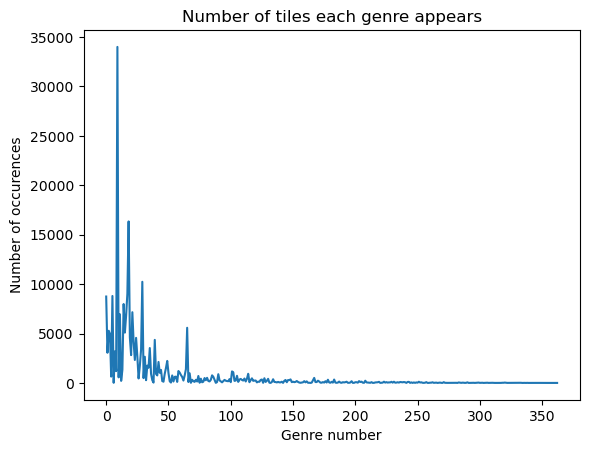

In [36]:
genres = {}

for d in movies['Movie genres']:
    for k, v in d.items():
        genres[v] = genres.get(v, 0)+1
            
count_threshold = 100
count = len(dict(filter(lambda pair: pair[1]>count_threshold, genres.items())))

print(f"Only {count} over {len(genres)} genres appear more than {count_threshold} times")
plt.plot(genres.values())
plt.ylabel('Number of occurences')
plt.xlabel('Genre number')
plt.title('Number of tiles each genre appears')
plt.show()

We see that a lot of genres are not often used. This if for example the case of the "Comedy Thriller" genre, that appears 91 times. We see that in fact it does not make much sense that "Comedy" and "Thriller" both appear together. We would thus like to cut any such genre into subgenres : "Comedy Thriller" becomes ["Comedy", "Thriller"]. To do so, we split the strings to obtain the subgenres. We then decide manually what to keep and what to leave, and write it into the file `"genres_dict.txt"`.

In [37]:
f = open('./Data/genres_dict.txt')
genres_dict = json.load(f)
f.close()
print(f'"Comedy Thriller" is now mapped to {genres_dict["Comedy Thriller"]}')

"Comedy Thriller" is now mapped to ['Comedy', 'Thriller']


Now, let's check how many genres we have:

In [38]:
new_genres = {}
for k, v in genres_dict.items():
    if isinstance(v, list) :
        for s in v :
            new_genres[s] = new_genres.get(s, 0)+1
    else : 
        new_genres[v] = new_genres.get(v, 0)+1
                
print(f"We have {len(new_genres)} new genres.")

We have 99 new genres.


In [39]:
#we get a list of unique genres (by converting a set to the list) contained in a given dictionary by using 
#the previously defined "genres_dict" which maps a genre to a list of genres
def get_genres_list(dictionary):
    genres_set = set()
    for genre in dictionary.values():
        new_genre = genres_dict[genre]
        if type(new_genre)==list:
            for split in new_genre:
                genres_set.add(split)
        else:
            genres_set.add(new_genre)
    return list(genres_set)

movies['Genres'] = movies['Movie genres'].apply(lambda dictionary : get_genres_list(dictionary))
movies.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie year,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001.0,"[Action, Supernatural, Western, Horror, Scienc..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",2000.0,"[Drama, Mystery, Biopic, Crime]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",1988.0,"[Drama, Crime]"


### Preprocessing the characters dataframe <a class="anchor" id="char_preprocessing"></a>


In [40]:
characters.sample(5)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
279765,10839638,/m/02qrmvj,1999-04-12,NaN,1986-10-27,M,1.65,/m/02w7gg,Gabriel Thomson,12.0,/m/0lyz9dc,NaN,/m/02h89k
198631,1091625,/m/04580c,2001,NaN,1981-08-05,F,1.60,NaN,Kou Shibasaki,19.0,/m/02vcxxp,NaN,/m/046fsq
446049,4922371,/m/0cvbvp,2001-01-20,Dr. Ann Beamer,1965-06-10,F,1.73,/m/02w7gg,Elizabeth Hurley,35.0,/m/0jxgwx,/m/0gx38rt,/m/01pnn3
249132,9392062,/m/0287110,1946-04-10,George Morgan,1897-10-06,M,NaN,NaN,Jerome Cowan,NaN,/m/0lv356p,/m/0lwbmgy,/m/06kq1h
15555,10206962,/m/02q56mk,2000-02-22,Sam Traxler,1971-03-16,M,1.83,NaN,Alan Tudyk,28.0,/m/0bhp3q6,/m/0bhp3q9,/m/02w29z


In the characters dataframe, we have the following interpretable columns:
- Movie release date
- Actor date of birth
- Actor gender
- Actor height
- Actor age at movie release

#### Movie release date <a class="anchor" id="rel_date"></a>


This is roughly the same as for the movies dataframe, so let's preprocess this in the same way.

In [41]:
characters['Movie year']=characters['Movie release date'].apply(lambda d: get_year(d) if type(d)==str else d)

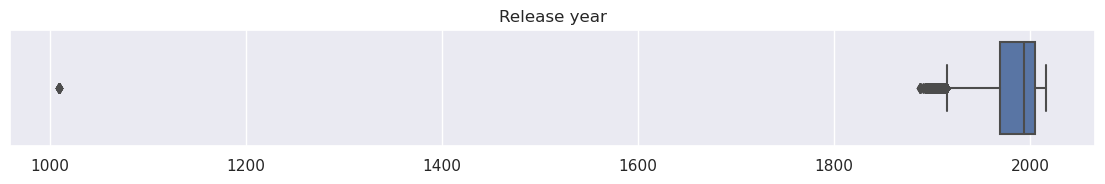

In [42]:
plot_boxplot(characters, 'Movie year', 'Release year')

We have the same outlier as before, so let's remove it again.

In [43]:
characters = characters[(characters['Movie year']>1010) | (characters['Movie year'].isna()==1)]

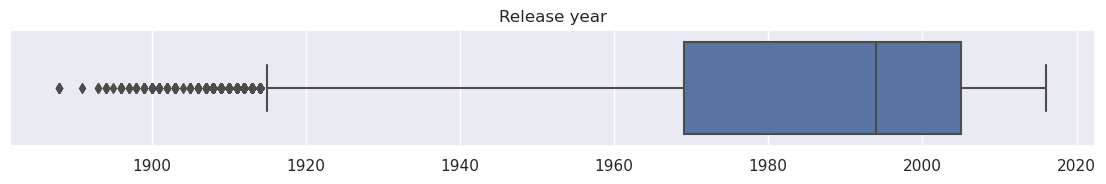

In [44]:
plot_boxplot(characters, 'Movie year', 'Release year')

In [45]:
characters['Movie year'].describe()

count    440659.000000
mean       1984.523101
std          25.257942
min        1888.000000
25%        1969.000000
50%        1994.000000
75%        2005.000000
max        2016.000000
Name: Movie year, dtype: float64

We have a similar distribution as before, but with less actor information before 1910, which makes sense. Note that here also, we are only interested in movies past 1900, so we filter out earlier ones:

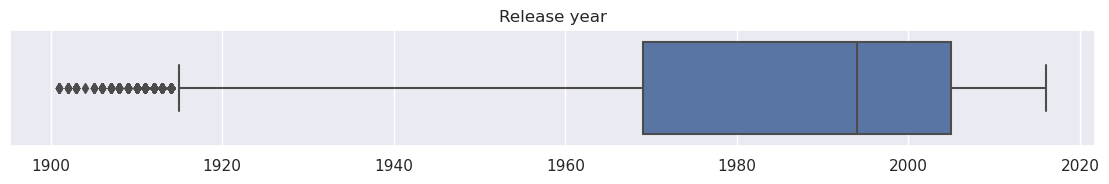

In [46]:
characters = characters[(characters['Movie year']>1900) | (characters['Movie year'].isna()==1)]
plot_boxplot(characters, 'Movie year', 'Release year')

#### Actor date of birth <a class="anchor" id="birth"></a>




In [47]:
characters['Date of birth']=characters['Actor date of birth'].apply(lambda d: get_year(d) if type(d)==str else d)

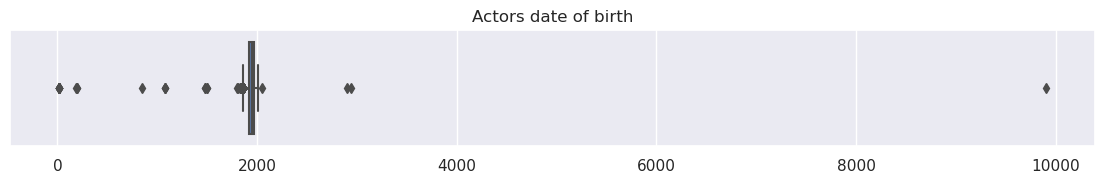

In [48]:
plot_boxplot(characters, 'Date of birth', 'Actors date of birth')

After having made sure that all birth years below 1800 are a mistake, we filter them out. Likewise, we filter out all birth dates above 2016, since the database ends with movie releases in 2016. We also want to remove all actors who were born after the movie release, as that does not make sense.

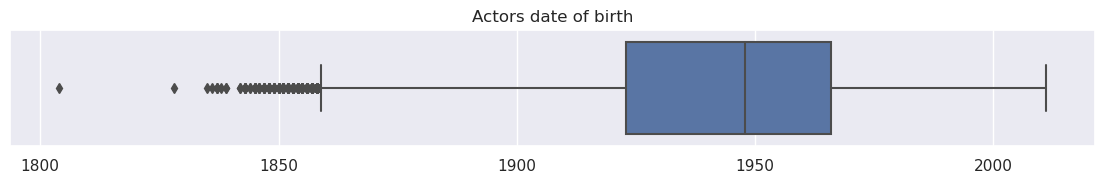

In [49]:
birth_date_in_range = (characters['Date of birth']>=1800) & (characters['Date of birth']<=2016)
characters = characters[birth_date_in_range | (characters['Date of birth'].isna()==1)]
plot_boxplot(characters, 'Date of birth', 'Actors date of birth')

In [50]:
characters['Born before movie'] = characters.apply(lambda row:row['Movie year'] >= row['Date of birth'], axis=1)
characters = characters[(characters['Born before movie']==1) | (characters['Date of birth'].isna()==1)]
characters.drop(columns="Born before movie", inplace=True)

In [51]:
characters['Date of birth'].describe()

count    334951.000000
mean       1943.082143
std          28.940422
min        1804.000000
25%        1923.000000
50%        1948.000000
75%        1966.000000
max        2008.000000
Name: Date of birth, dtype: float64

Now, the distribution of birth years makes a lot more sense, with mean 1943 and 50% of birth dates between 1923 and 1966. However, let's have a look at how much data is missing.

There is 24.06% of data missing.


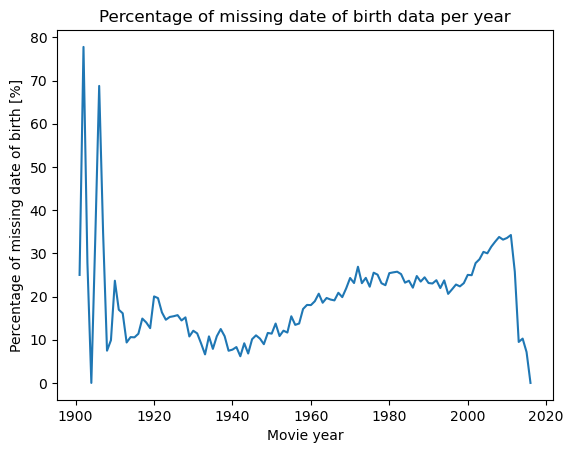

In [52]:
print(f"There is {get_missing_values_percentage(characters, 'Date of birth'):.2f}% of data missing.")
plot_missing_values(characters, 'Date of birth')

We have a lot of missing data, but especially for the earlier years (up until 1910s). Afterwards, there's around 20% of birth years data missing every year.

#### Actor gender <a class="anchor" id="char_gender"></a>


In [53]:
characters['Actor gender'].unique()

array(['F', 'M', nan], dtype=object)

Since there are no incorrect values or outliers, let's look at how much data is missing:

There is 10.33% of data missing.


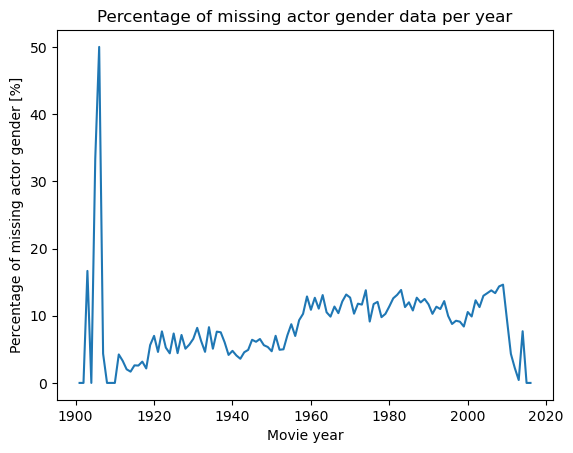

In [54]:
print(f"There is {get_missing_values_percentage(characters, 'Actor gender'):.2f}% of data missing.")
plot_missing_values(characters, 'Actor gender')

Compared to other features, it seems we have more of the data!

#### Actor height <a class="anchor" id="height"></a>


In [55]:
characters['Actor height (in meters)'].describe()

count    151095.000000
mean          1.789108
std           4.409850
min           0.610000
25%           1.680000
50%           1.750000
75%           1.830000
max         510.000000
Name: Actor height (in meters), dtype: float64

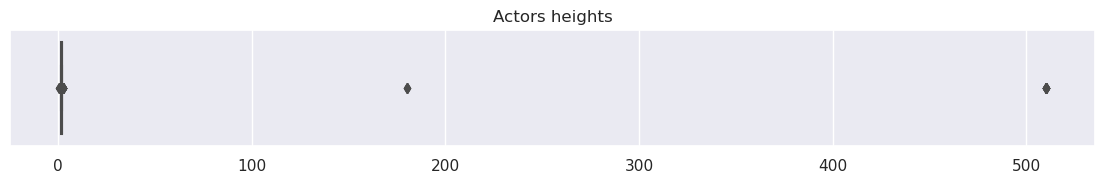

In [56]:
plot_boxplot(characters, 'Actor height (in meters)', 'Actors heights')

There are two huge outliers, one aroung 180 and one around 510. Let's filter them out.

In [57]:
heights = characters['Actor height (in meters)']
characters = characters[(heights < 100) | (heights.isna()==1)]

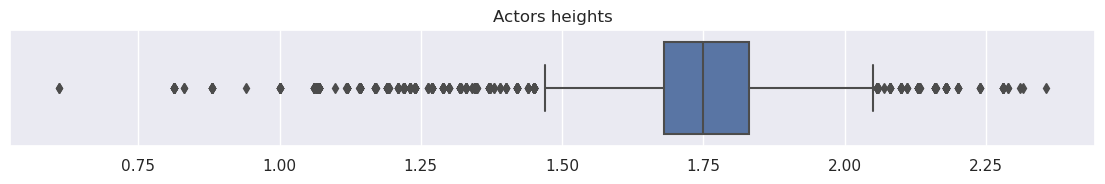

In [58]:
plot_boxplot(characters, 'Actor height (in meters)', 'Actors heights')

Now, the distribution makes more sense, we don't seem to have outliers anymore.

#### Actor age at movie release <a class="anchor" id="age_release"></a>


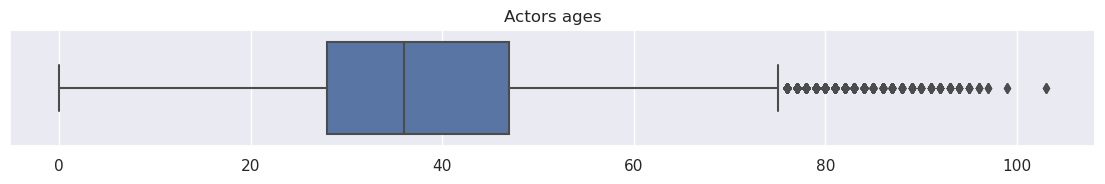

In [59]:
plot_boxplot(characters, 'Actor age at movie release', 'Actors ages')

Note that a lot of actors had negative ages, but these were already (coincidentally) filtered out when we dealt with the actor date of birth. Otherwise, we could use the following code (which now does not modify the dataframe in any way).

In [60]:
ages = characters['Actor age at movie release']
characters = characters[(ages >= 0) | (ages.isna()==1)]

In [61]:
characters['Actor age at movie release'].describe()

count    292160.000000
mean         37.891761
std          14.085582
min           0.000000
25%          28.000000
50%          36.000000
75%          47.000000
max         103.000000
Name: Actor age at movie release, dtype: float64

Now, the ages are more logically distributed, mostly between 28 and 47. Let's check how much data is missing:

There is 33.76% of data missing.


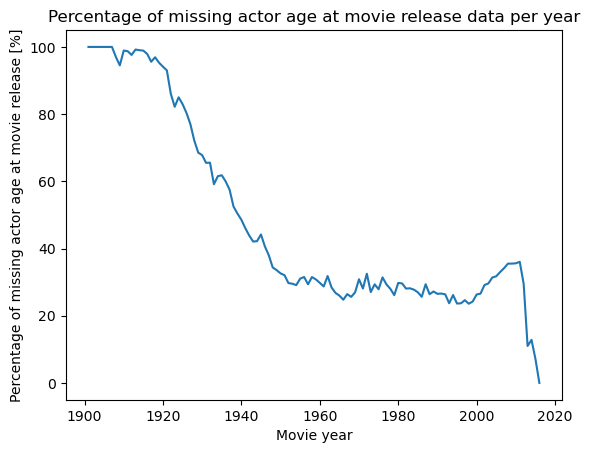

In [62]:
print(f"There is {get_missing_values_percentage(characters, 'Actor age at movie release'):.2f}% of data missing.")
plot_missing_values(characters, 'Actor age at movie release')

Starting around 1920, we have decreasing percentage of missing data for the actor ages, which before about 30% starting 1950. Note that before 1920, there is a lot of missing data and/or a lot of variance in the percentage of missing data for any columns we're looked at so far. This makes sense because there were less movies back then, and the values were less systematically stored than nowadays.

#### Actor persona  <a class="anchor" id="persona"></a>


We decided to base our analysis on the results of the LDA paper $^{[1]}$. The authors extracted some persona types from the summaries of the movies. We will use these persona types to analyze the characters. Running the code results in new dataframes, containing information that we can exploit. 
Notably, the file `lda.log.tsv` contains notably the characters for each movie, with their persona types corresponding to the maximum of the vector of probilities of persona types for each character. This vector of persona types is contained in the column *Estimated Trope* below. We will however only use the *Persona Type* and assign it to each character in our character dataframe.

Another important information is the fact that not all results of the code are relevant. Indeed, some of the row contains not characters but places (e.g. Hogwarts) or general names (e.g. they, the trap, etc.)
We can thus filter these rows by removing them. We then add these persona types to our characters dataframe by merging the dataframe and adding the types to existing characters in our original data. In order to avoid confusion on identical character names (i.e. John Smith is a common name that could be present in different movies), the merging is done on the character name and the movie ID.

Note that the original file was too big to be put on git. It contains the following columns: 'Character ID', 'Wikipedia movie ID', 'Movie Title', 'Character name', 'Named as', 'Token occurences', 'Persona Type', 'Estimate Trope', which correspond respectively to the identifiant for the identified character, the identifiant of the movie, the title of the movie, the official name of the character, the name of the character as it appears in the movie, the number of occurences of the character in the movie, the persona type of the character and the vector of probability for the persona of the character.

[1]: Bamman, O'Connor and Smith (2013) *Learning Latent Personas of Film Characters* [(ACL)]([http://aclweb.org/anthology/P/P13/P13-1035.pdf])

In [63]:
colnames = ['Character ID', 'Wikipedia movie ID', 'Movie Title', 'Character name', 
            'Named as', 'Token occurences', 'Persona Type', 'Estimate Trope']
lda_log = pd.read_csv(path_lda + 'lda.log.tsv', sep='\t', names = colnames)

# drop all 'ID' columns starting with 'e' as they are not in our characters dataset
lda_log = lda_log[~lda_log['Character ID'].str.startswith('e')]

characters.set_index(['Wikipedia movie ID', 'Character name'], inplace=True)
characters_persona = characters.merge(lda_log[['Wikipedia movie ID', 'Character name','Persona Type']], 
                                      on=['Wikipedia movie ID', 'Character name'], how='left')

In [64]:
characters_persona.head(2)

,Wikipedia movie ID,Character name,Freebase movie ID,Movie release date,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,Movie year,Date of birth,Persona Type
0,975900,Akooshay,/m/03vyhn,2001-08-24,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0,1958.0,NaN
1,975900,Lieutenant Melanie Ballard,/m/03vyhn,2001-08-24,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0,1974.0,35.0


### Preprocessing the summaries dataframe <a class="anchor" id="summary"></a>


There is not much to preprocess for the summaries dataframe, but we can merge the movies and the summaries and see how much data is missing. We perform a left merge instead of an outer because if we have only the summary but no movie name, release date or anything else, we can't do anything with that data.

In [65]:
movies_with_summaries = movies.merge(summaries, how='left')

There is 48.30% of data missing.


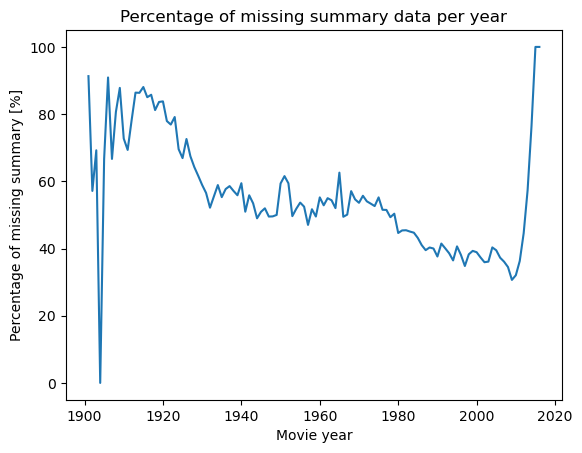

In [66]:
print(f"There is {get_missing_values_percentage(movies_with_summaries, 'Summary'):.2f}% of data missing.")
plot_missing_values(movies_with_summaries, 'Summary')

This shows us that we don't have a lot of summaries data, only half the movies have a summary.

### IMDB ratings preprocessing <a class="anchor" id="IMDB"></a>


#### Loading the ratings <a class="anchor" id="load_rate"></a>


First, we need to load the ratings.

In [67]:
query = '''
        SELECT DISTINCT ?item ?IMDb_ID ?freebase_id ?title WHERE {
            ?item p:P31/ps:P31/wdt:P279* wd:Q11424 .
            ?item wdt:P345 ?IMDb_ID .
            ?item wdt:P646 ?freebase_id .
            ?item wdt:P1476 ?title .
            ?item wdt:P577 ?pub_date
            FILTER(YEAR(?pub_date) <= 2012).
        }
'''

WIKIDATA_QUERY_URL = 'https://query.wikidata.org/sparql'
# This function is based on this webpage : https://query.wikidata.org/
# It makes a call to the wiki data query system in order to obtain both the freebase AND imdb ids. 
# This allows us to use properly the imdb ratings data dump
def wikidata_query(query, file):
    
    request = requests.get(url=WIKIDATA_QUERY_URL, params={'format':'json', 'query':query})
    jobj = request.json()
    
    with open(file, 'w') as file:
        json.dump(jobj, file)

In [68]:
wikidata_query(query, './Data/Ratings/wikidata.json')

In [69]:
f = open('./Data/Ratings/wikidata.json')
jdata = json.load(f)
f.close()

values = {
    'IMDb ID': [entry['IMDb_ID']['value'] for entry in jdata['results']['bindings']],
    'Freebase movie ID': [entry['freebase_id']['value'] for entry in jdata['results']['bindings']],
    'Wikidata title': [entry['title']['value'] for entry in jdata['results']['bindings']],
}

freebase_imdb_ids = pd.DataFrame(values)
display(freebase_imdb_ids)

,IMDb ID,Freebase movie ID,Wikidata title
0,tt0071866,/m/048hrf,Mr. Majestyk
1,tt1119191,/m/04ybhxs,The Killing Room
2,tt0425295,/m/03gtkbc,Niagara Motel
3,tt0071565,/m/02r3qq,ゴジラ対メカゴジラ
4,tt0099487,/m/01s3vk,Edward Scissorhands
...,...,...,...
85201,tt0116893,/m/0crtbp9,Liszt's Rhapsody
85202,tt2191612,/m/0kf9_3n,La sirga
85203,tt0071572,/m/01hcp2c,"Good to See You Again, Alice Cooper"
85204,tt1096939,/m/02rh26r,The Biggest Bang


We merge the dataframes into one dataframe that contains both the freebase and imdb ids.

In [70]:
movies_imdbID = movies.merge(freebase_imdb_ids, on=['Freebase movie ID'], how = 'left')
movies_imdbID.head(1)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie year,Genres,IMDb ID,Wikidata title
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001.0,"[Action, Supernatural, Western, Horror, Scienc...",tt0228333,Ghosts of Mars


Now, we can use the imdb ID to obtain the imdb rating of the movies.

In [71]:
ratings = pd.read_csv('./Data/Ratings/imdb_ratings.tsv', sep='\t', header = 0)
ratings.rename(columns = {'tconst': 'IMDb ID', 'averageRating': 'Average rating',
                          'numVotes' : 'Number of votes'}, inplace = True)

movies_augmented = movies_imdbID.merge(ratings, on=['IMDb ID'], how = 'left')

nb_movies = movies_augmented['Average rating'].size
nb_missing = movies_augmented['Average rating'].isna().sum()
ratio = nb_missing/nb_movies 

print(f"{nb_movies-nb_missing} of {nb_movies} movies ({(1-ratio)*100:.2f}%) have an average rating in IMDB")
print(f"There is {ratio*100:.2f}% of average ratings in IMDB missing in total.")
movies_augmented.head(3)

54709 of 82149 movies (66.60%) have an average rating in IMDB
There is 33.40% of average ratings in IMDB missing in total.


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie year,Genres,IMDb ID,Wikidata title,Average rating,Number of votes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001.0,"[Action, Supernatural, Western, Horror, Scienc...",tt0228333,Ghosts of Mars,4.9,56887.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",2000.0,"[Drama, Mystery, Biopic, Crime]",NaN,NaN,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",1988.0,"[Drama, Crime]",tt0094806,Brun bitter,5.6,40.0


#### Preprocessing the ratings <a class="anchor" id="Preprocessing_rate"></a>


What we have now is a dataframe with movies and ratings, joined. Since we used the already preprocessed movies dataframe, all we need to do is check the values we added, so the only new columns are "IMDb ID", "Wikidata title", "Average rating" and "Number of votes".

First, we can't do anything on "IMDb ID": there is no preprocessing to do, outliers to find, etc.

We choose to ignore the "Wikidata title" because we already have and will rely on "Movie name" from the movies dataframe if necessary. This is because it is more compatible with the characters dataframe (the format is exactly the same).

We still have "Average rating" and "Number of votes".

We can't just remove outliers because no matter how different from the others a value is, it could be correct (unlike movie dates from the 11th century, like we filtered out above). However, we know the ratings are supposed to be between 1 and 10, so first, let's make sure that they are. The second thing we do is see how many missing values there are for "Average rating" and "Number of votes". 

#### Average rating <a class="anchor" id="average_rate"></a>


In [72]:
movies_augmented['Average rating'].describe()

count    54709.000000
mean         6.215813
std          1.127247
min          1.000000
25%          5.600000
50%          6.300000
75%          7.000000
max         10.000000
Name: Average rating, dtype: float64

Indeed, the values are between 1 and 10, so there are no mistakes (that we know of). The mean is aroung 6.2, which seems plausible for imdb ratings.

There is 33.40% of data missing.


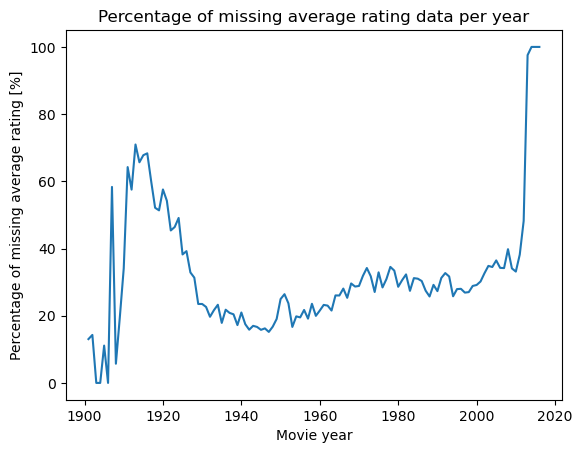

In [73]:
print(f"There is {get_missing_values_percentage(movies_augmented, 'Average rating'):.2f}% of data missing.")
plot_missing_values(movies_augmented, 'Average rating')

#### Number of votes <a class="anchor" id="vote"></a>


In [74]:
movies_augmented['Number of votes'].describe()

count    5.470900e+04
mean     1.349741e+04
std      7.219071e+04
min      5.000000e+00
25%      1.710000e+02
50%      7.350000e+02
75%      3.307000e+03
max      2.815662e+06
Name: Number of votes, dtype: float64

There is 33.40% of data missing.


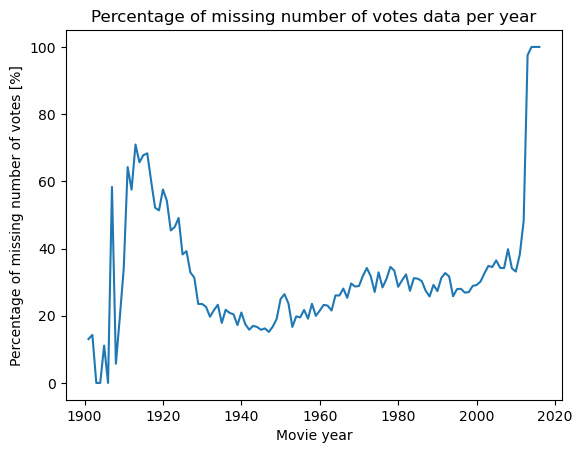

In [75]:
print(f"There is {get_missing_values_percentage(movies_augmented, 'Number of votes'):.2f}% of data missing.")
plot_missing_values(movies_augmented, 'Number of votes')

Logically, sinse they come from the same dataset and if one is NaN, the other is NaN as well, the percentage of missing data and distribution over the years is exactly the same for both number of votes and average rating.

### Removing unnecessary columns <a class="anchor" id="remove_col"></a>


Given the project we chose, there are a lot of columns in the dataframe that we don't need, and thus don't need to keep uselessly. Therefore, we remove the columns we won't need as follows. For the characters dataframe, we remove 

- Freebase movie ID
- Movie release date (was preprocessed so the data is consistent)
- Actor date of birth (was preprocessed so the data is consistent)
- Actor height (in meters)
- Actor ethnicity (Freebase ID)
- Freebase character/actor map ID (redundent information with "Freebase character ID" and "Freebase actor ID"

We also rename the remaining columns to make them more legible.

In [76]:
characters_persona.drop(columns=['Freebase movie ID', 'Movie release date', 'Actor date of birth', 
                         'Actor height (in meters)', 'Actor ethnicity (Freebase ID)', 
                         'Freebase character/actor map ID'], inplace=True)

characters_persona.rename(columns={'Wikipedia movie ID': 'movie_id', 'Character name': 'c_name',
                           'Actor gender': 'a_gender', 'Actor name': 'a_name',
                           'Actor age at movie release': 'a_age', 'Freebase character ID': 'c_id',
                           'Freebase actor ID': 'a_id', 'Movie year': 'movie_release',
                           'Date of birth': 'a_birth_year', 'Persona Type': 'persona'}, inplace=True)

The result is much more comfortable to read:

In [77]:
characters_persona.head(3)

,movie_id,c_name,a_gender,a_name,a_age,c_id,a_id,movie_release,a_birth_year,persona
0,975900,Akooshay,F,Wanda De Jesus,42.0,/m/0bgcj3x,/m/03wcfv7,2001.0,1958.0,NaN
1,975900,Lieutenant Melanie Ballard,F,Natasha Henstridge,27.0,/m/0bgchn4,/m/0346l4,2001.0,1974.0,35.0
2,975900,Desolation Williams,M,Ice Cube,32.0,/m/0bgchn_,/m/01vw26l,2001.0,1969.0,NaN


We now do the same for `movies_augmented`. Our project is based on movies more than characters, so we keep most columns but rename them to have names that are easier to handle. The only columns we remove are:

- Freebase movie ID (we rely on the wikipedia movie id only)
- Movie release date (was preprocessed so the data is consistent)
- Movie genres (was preprocessed for easier data handling in the project)
- Wikidata title (we already have the movie name)

In [78]:
movies_augmented.drop(columns=['Freebase movie ID', 'Movie release date', 'Movie genres',
                               'Wikidata title'], inplace=True)

movies_augmented.rename(columns={'Wikipedia movie ID': 'movie_id', 'Movie name': 'movie_name',
                           'Movie box office revenue': 'revenue', 'Movie runtime': 'runtime',
                           'Movie languages': 'languages', 'Movie countries': 'countries',
                           'Movie year': 'movie_release', 'Genres': 'genres', 'IMDb ID': 'imdb_id',
                           'Average rating': 'rating', 'Number of votes': 'nb_votes'}, inplace=True)

movies_augmented.head(3)

,movie_id,movie_name,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes
0,975900,Ghosts of Mars,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},2001.0,"[Action, Supernatural, Western, Horror, Scienc...",tt0228333,4.9,56887.0
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},2000.0,"[Drama, Mystery, Biopic, Crime]",NaN,NaN,NaN
2,28463795,Brun bitter,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},1988.0,"[Drama, Crime]",tt0094806,5.6,40.0


### Dropping Duplicates <a class="anchor" id="drop_dup"></a>


We still may have some duplicates in the dataframe, so now that we removed all useless columns, we make sure to re,ove all duplicates before saving the preprocessed dataframes.

In [79]:
characters_persona.drop_duplicates(subset=['movie_id', 'c_id', 'a_id'], inplace=True)
movies_augmented.drop_duplicates(subset=['movie_id', 'imdb_id'], inplace=True)

### Saving <a class="anchor" id="Saving"></a>


Now that all this preprocessing has been done, let's save the dataframes to tsv files so that our other notebooks can load them without having to rerun all of this! Note that we don't save the summaries dataframe because nothing was done on it and the merging with movies was a simple left join. Note also that we don't save the `movies` dataframe because we want to have the ratings, so having `movies_augmented` is enough (since it is the movies joined with their ratings).

In [80]:
characters_persona.to_csv('./Data/Preprocessed/preprocessed_characters.tsv', sep="\t", index=False) 
movies_augmented.to_csv('./Data/Preprocessed/movie.metadata.augmented.tsv', sep='\t', index=False)

The following code can and will be used in other notebooks to recover the final results of the preprocessing of the initial dataframes:

In [81]:
loaded_characters = pd.read_csv('./Data/Preprocessed/preprocessed_characters.tsv', delimiter='\t')
loaded_movies_augmented = pd.read_csv('./Data/Preprocessed/movie.metadata.augmented.tsv', delimiter='\t')

Note that the loaded dataframe and saved dataframes are not exactly the same because in the loaded dataframes, the indices range from "0" to "number of rows", whereas in the saved dataframe, the indices range from "0" to "number of rows before preprocessing", with some missing values in between because the entries we filtered out were not (necessarily) the ones with largest indices. However, this is a small detail that will not affect the analysis or anything else, it's just something to be aware of.

### Preprocessing the GPT questions

For this project, we've asked GPT some questions about the troped of our movies. Let's have a look at the answers! Note that the code to obtain there answers can be found in `gpt_methods.ipynb`.

In [82]:
romance_with_binary = pd.read_csv('./Data/Preprocessed/romances.with.binary.tsv', delimiter='\t')
romance_with_binary.head(3)

,index,movie_id,movie_name,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers
0,12,6631279,Little city,NaN,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"['Drama', 'Comedy', 'Romance', 'Ensemble']",tt0119548,5.8,1129.0,01001000000001111000
1,22,21926710,White on Rice,NaN,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"['Comedy', 'Romance', 'Indie']",tt0892904,6.1,545.0,00000001000001000100
2,38,26067101,Siam Sunset,NaN,91.0,{},"{'/m/0chghy': 'Australia', '/m/0ctw_b': 'New Z...",1999.0,"['World Cinema', 'Comedy', 'Romance', 'Indie']",tt0178022,6.4,1240.0,01000000001000001000


The following code loads the questions as well as creates dictionaries mapping indices to their questions and indices to the question names, which were created manually to give understandable but short names to each question.

In [83]:
f = open('Data/trope_questions.txt', 'r')

line = f.readline()
questions = {}

index = -1
while len(line)!=0:
    questions[index] = line.strip()
    line = f.readline()
    index += 1
    
questions = {index: questions[index] for index in range(20)}

question_names = {   0: 'Interrupted wedding',
                     1: 'Best friends to lovers',
                     2: 'Enemies to lovers',
                     3: 'Social status',
                     4: 'Serious illness',
                     5: 'Love at first sight',
                     6: 'Meet-cute',
                     7: 'Break up',
                     8: 'One night stand',
                     9: 'Different relationships',
                     10: 'Love triangle',
                     11: 'Sad ending',
                     12: 'LGBT+',
                     13: 'Infidelity',
                     14: 'Dating as a bet',
                     15: 'Fake dating',
                     16: 'Bad boy',
                     17: 'Holiday',
                     18: 'Regretful empowered woman',
                     19: 'Reunion'}

We are only interested in preprocessing the binary answers, so let's reduce our dataframe to that and check the possible lengths of the binary answers (which should be 20, one bit per question asked):

In [84]:
gpt_answers = romance_with_binary[['movie_id', 'binary_answers']].copy()
gpt_answers['response_length'] = gpt_answers['binary_answers'].apply(lambda ans: len(ans))
gpt_answers.head(3)

,movie_id,binary_answers,response_length
0,6631279,01001000000001111000,20
1,21926710,00000001000001000100,20
2,26067101,01000000001000001000,20


In [85]:
def print_length_of_string_occurrences(df, print_incorrect_rows=False):
    for length in df['response_length'].unique():
        print(f'{len(df[df.response_length==length])} row(s) has/have length {length}')
        if print_incorrect_rows and length != 20:
            print(df[df.response_length==length])

In [86]:
print_length_of_string_occurrences(gpt_answers)

5811 row(s) has/have length 20
70 row(s) has/have length 21
1 row(s) has/have length 19


We noticed from playing around with the data that some binary answers have length 21, when, in fact, there are only 20 bits. For example, the index '1935', printed below. We can see that the reason the length is 21 is the whitespace at the end. Clearly, this is not an issue. There are also some occurrences with other characters at the end (like '-') which, again, don't interfere with the result, so we can just remove those characters.

In [87]:
gpt_answers.loc[1935]['binary_answers'], gpt_answers.loc[1935]['response_length']

('01001010000001001010 ', 21)

To fix this, let's map the binary answers to the corrected versions (without whitespaces etc), and then see their lengths.

In [88]:
bits = {'0', '1', '2'}
gpt_answers['binary_answers'] = gpt_answers['binary_answers'].apply(lambda b: ''.join(c for c in b if c in bits))
gpt_answers['response_length'] = gpt_answers['binary_answers'].apply(lambda ans: len(ans))

In [89]:
print_length_of_string_occurrences(gpt_answers, True)

5881 row(s) has/have length 20
1 row(s) has/have length 19
      movie_id       binary_answers  response_length
1569   2210682  0000000000111100010               19


So now, all rows are correct except one. We keep all the correct ones and replace the others by strings of "2"'s (20 concatenated two's) and drop the `response_length` column, since all the strings are now of length 20.

In [90]:
gpt_answers['binary_answers'] = gpt_answers['binary_answers'].apply(lambda b: b if len(b)==20 else '2'*20)
gpt_answers.drop(columns=['response_length'], inplace=True)

In [91]:
gpt_answers.head(5)

,movie_id,binary_answers
0,6631279,01001000000001111000
1,21926710,00000001000001000100
2,26067101,01000000001000001000
3,12053509,01000000000111011000
4,7028314,00010011010001001000


In [92]:
for q_nb, question in questions.items():
    gpt_answers[f'q_{q_nb}'] = gpt_answers['binary_answers'].apply(lambda b: int(b[q_nb]))
    
gpt_answers.head(5)

,movie_id,binary_answers,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,...,q_10,q_11,q_12,q_13,q_14,q_15,q_16,q_17,q_18,q_19
0,6631279,01001000000001111000,0,1,0,0,1,0,0,0,...,0,0,0,1,1,1,1,0,0,0
1,21926710,00000001000001000100,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,26067101,01000000001000001000,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,12053509,01000000000111011000,0,1,0,0,0,0,0,0,...,0,1,1,1,0,1,1,0,0,0
4,7028314,00010011010001001000,0,0,0,1,0,0,1,1,...,0,0,0,1,0,0,1,0,0,0


Now that our preliminary preprocessing is done, let's have a look at the distributions to try and detect anomalies. So let's plot how many answers to the questions were negative, positive and unknown for each question.

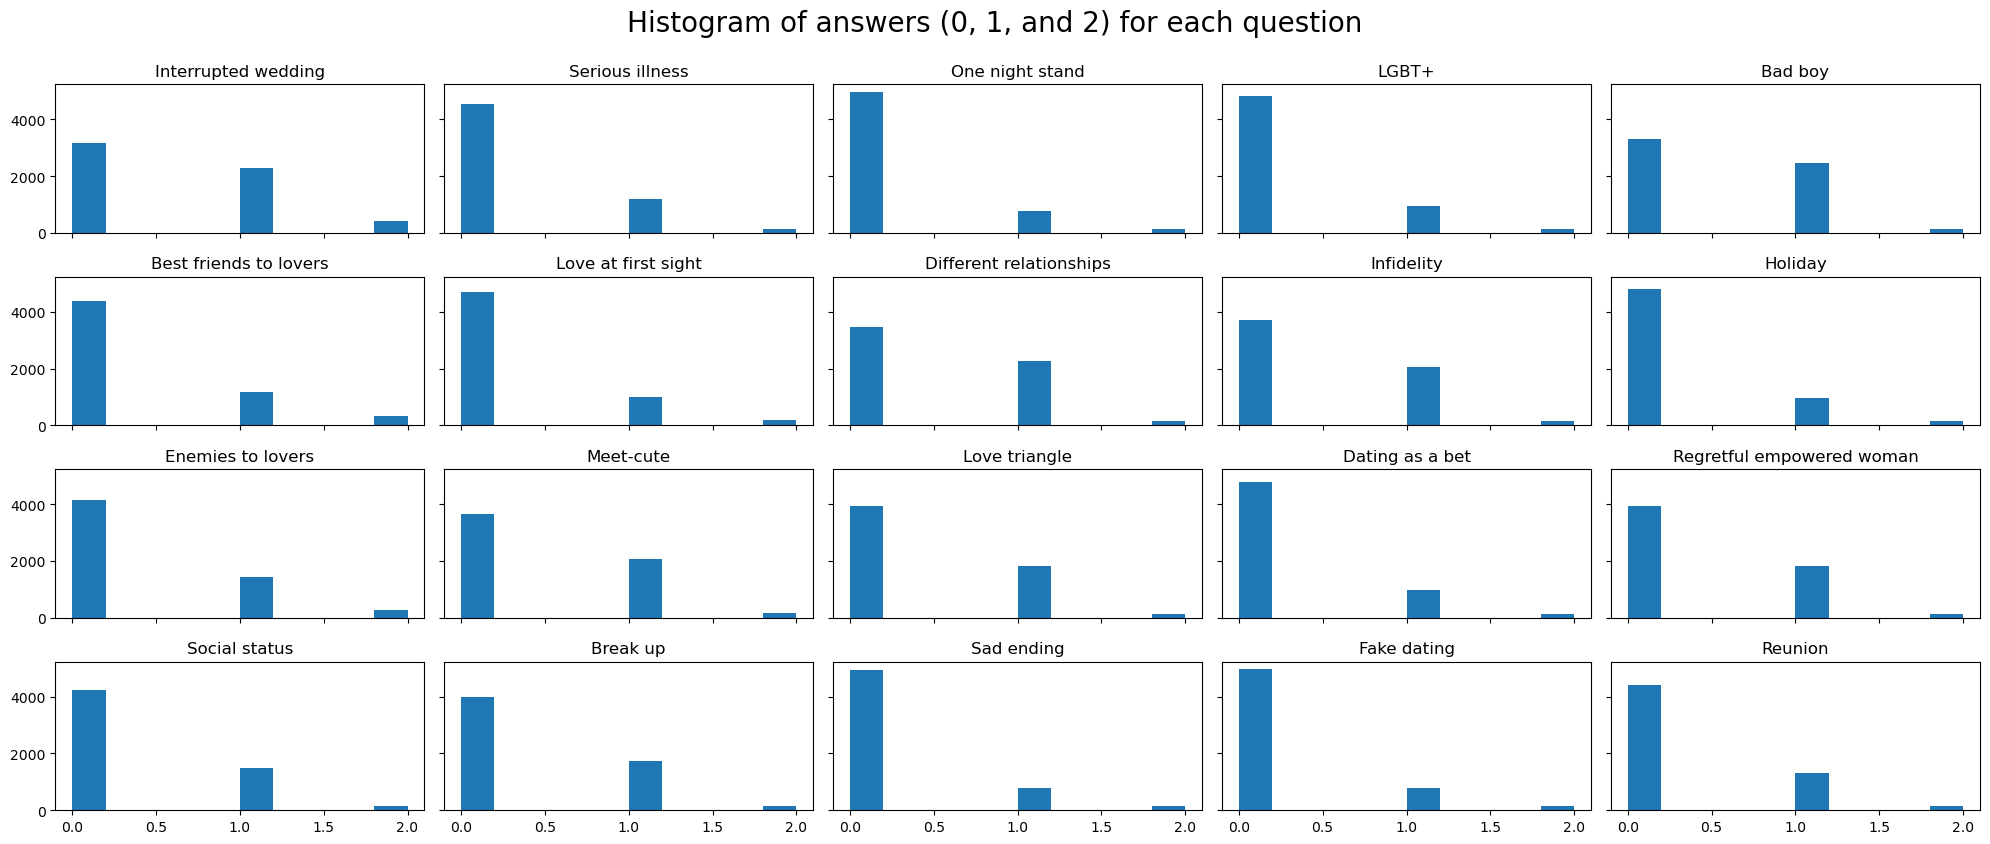

In [93]:
def plot(df, q_names):
    fig, ax = plt.subplots(4, 5, figsize= (20,8), sharey = True, sharex = True)

    for i in range(20):
        sbplt = ax[i%4, math.floor(i/4)]
        sbplt.hist(df[f'q_{i}'])
        sbplt.set_title(q_names[i])

    fig.tight_layout()
    fig.suptitle('Histogram of answers (0, 1, and 2) for each question', y=1.05, fontsize=20)
    plt.show()

plot(gpt_answers, question_names)

Let's see what this plot looks like if we only consider positive and negative answers (replacing the '2's by missing values, which is what they mean):

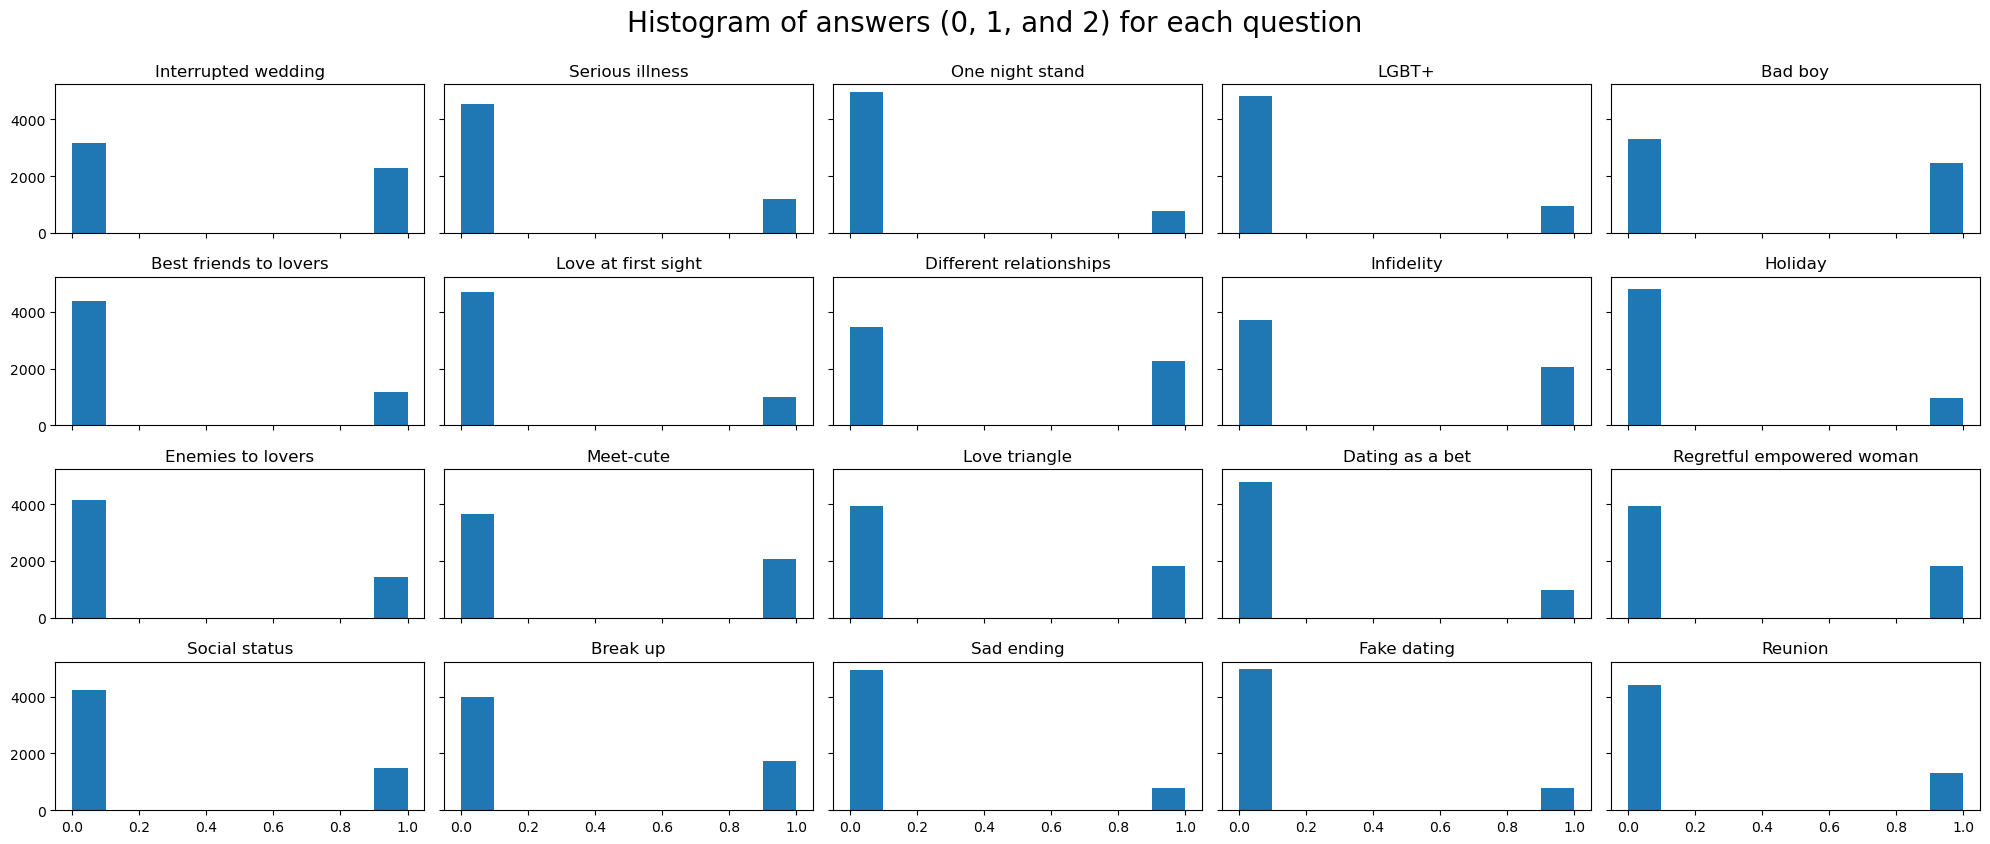

In [94]:
gpt_answers_nan = gpt_answers.replace(2, np.NaN, inplace=False)
plot(gpt_answers_nan, question_names)

It doesn't seem like anything is wrong, incorrect, but let's make it easier to compare with pie charts instead to facilitate comparison of percentages. Note that this helper function can be found in an extra python file, since it will also be used in `Statistics Pipeline.ipynb`.

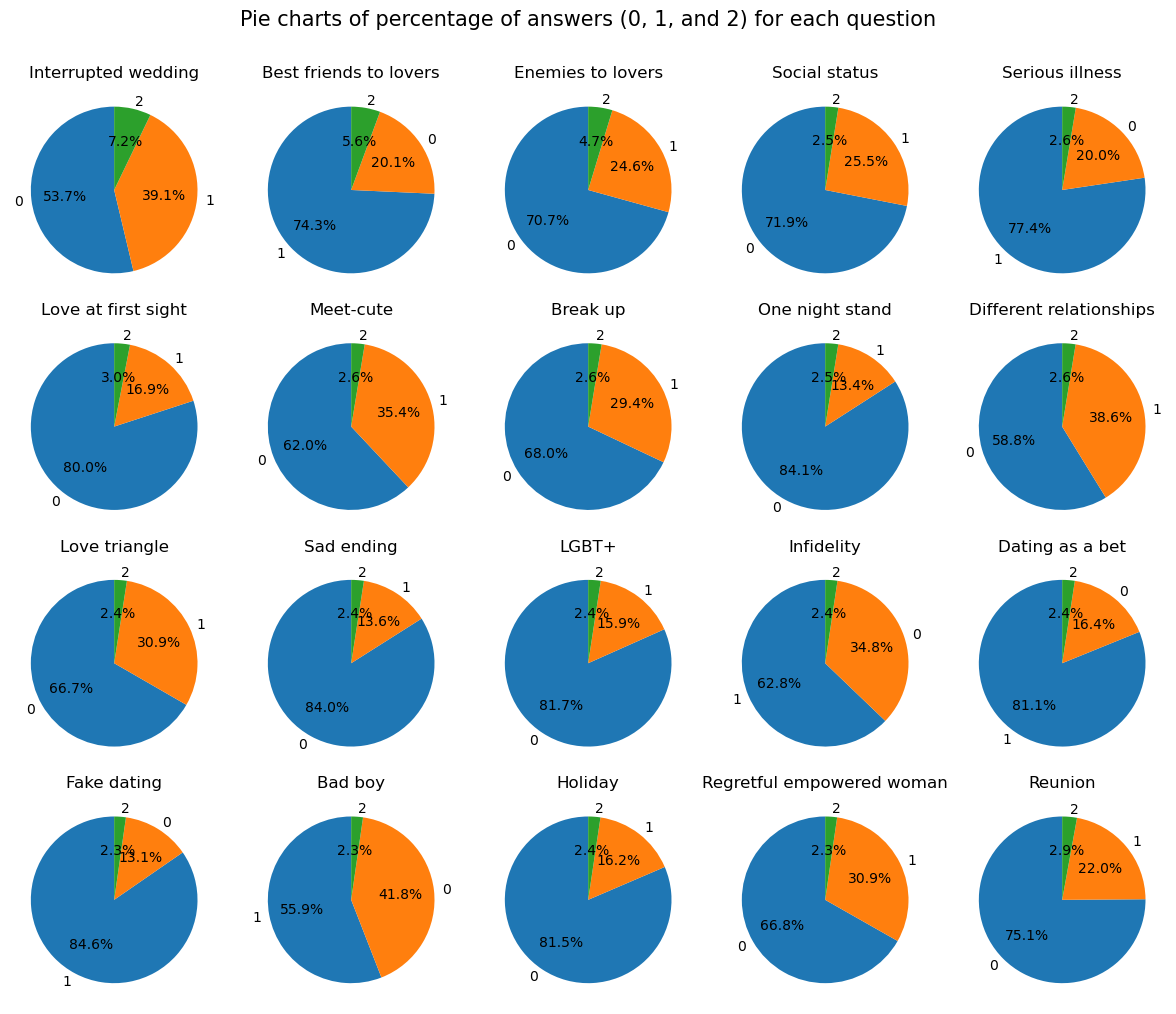

In [95]:
plot_gpt_answers_pie_charts(gpt_answers, question_names)

It seems that there are a lot of missing values. However, if these are the same for all subquestions, it makes sense to remove them (i.e., if an entry does not have any information and has "unknown" for all the questions, let's remove it altogether. 

Likewise, we remove all 0's. This is because sometimes, movies are classified as romance even though they aren't (really). For example, some movies like "Harry Potter" and "Spirit"  are classified as "Romance", but clearly, that is not the kind of movie we're interested in. These movies should not be considered romance movies in the first place ! It is thus good that GPT outputs a 00000000000000000000 when analyzing them. Indeed, the answer to all questions we asked is "no".

We also remove all entries containing just 0's and 2's, because if the answer is either no or unknown, it is probably not a romance movie anyway. In short, we keep all strings that have at least one "1".

Note that we use `binary_answers` for this (not the encoding done previously with one column per question) for simplicity.

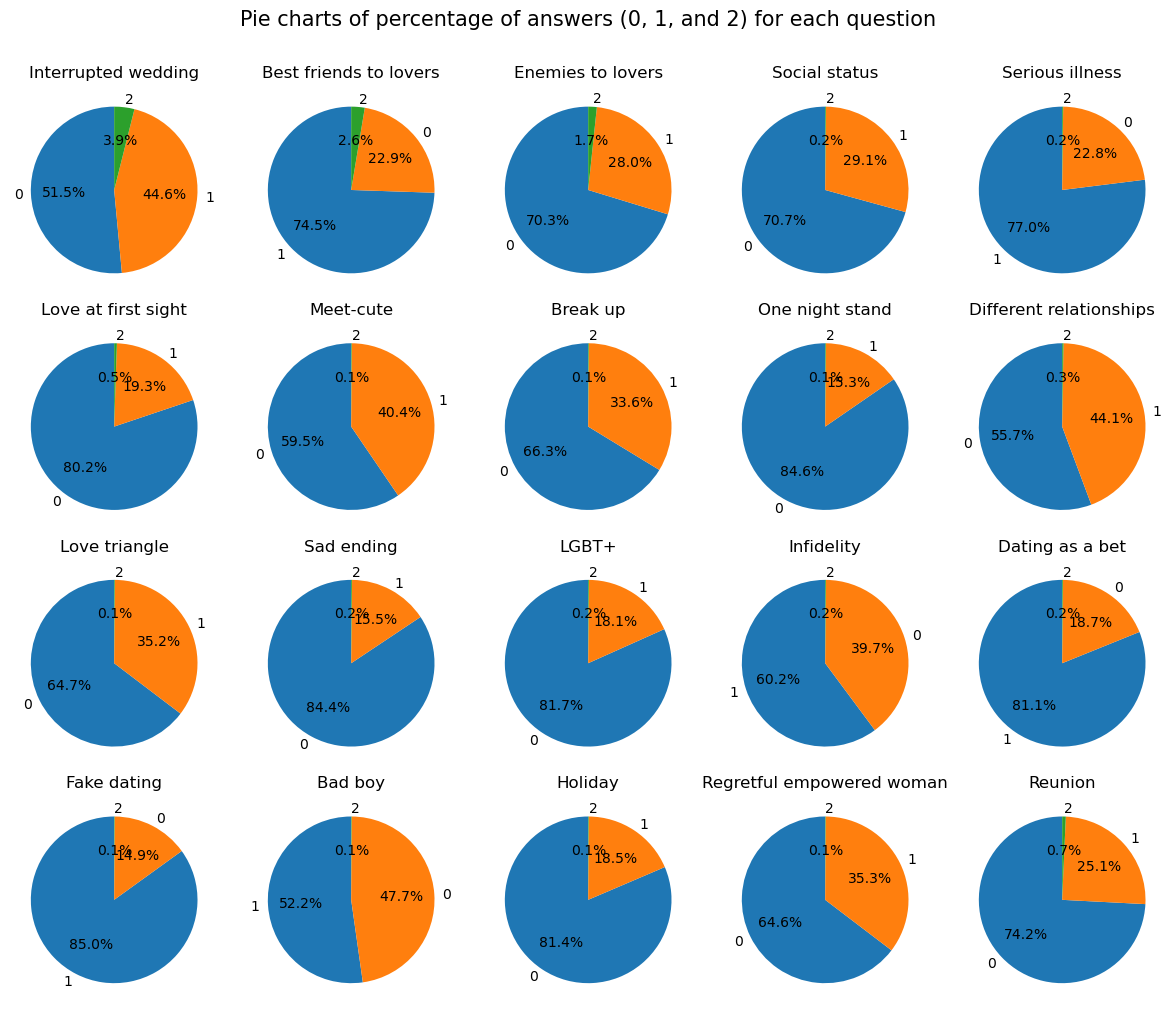

In [96]:
relevant_answers = gpt_answers[gpt_answers['binary_answers'].str.contains('1')].copy()
plot_gpt_answers_pie_charts(relevant_answers, question_names)

Indeed, there are far less unknowns for each question! It made sense to remove them.

In [97]:
len(relevant_answers)

5159

For simplicity, we also convert our questions to a dataframe and store it.

In [98]:
names_df = pd.DataFrame.from_dict(question_names, orient='index', columns=['name'])
questions_df = pd.DataFrame.from_dict(questions, orient='index', columns=['question'])
questions_info = pd.concat([names_df, questions_df], axis=1).reset_index()
questions_info.sample(2)

,index,name,question
0,0,Interrupted wedding,- Is there a wedding stopped at the altar trope ?
1,1,Best friends to lovers,- Is there a best friend to lovers trope ?


In [99]:
questions_info['q_nb'] = questions_info.apply(lambda row: f'q_{row["index"]}', axis=1)

In [100]:
questions_info.to_csv('./Data/Preprocessed/questions.tsv', sep="\t", index=False) 

Before, we removed all questions that don't contain at least one 1. This gives us a rationale to trim even more the dataset : if a movie contains only one of the 20 clichés, is it in fact a romance movie ? It seems that most of the all strings with a single 1 are in fact from movies that are not romance centered at all. We thus choose an (arbitrary) threshold to consider a movie "Romance" : it should contain at least 3 positive answers.

We should expect, after keeping only movies with 3 positive answers or more, to have around 4500 movies.

In [101]:
relevant_answers['total'] = relevant_answers[questions_info['q_nb']].sum(axis = 1)
relevant_answers = relevant_answers[relevant_answers['total'] >= 3]
len(relevant_answers)

4658

So we are left with roughly 5200 movies. Now that our preprocessing is done, let's save the newly created dataframe so we can recover it for our analysis later on.

In [102]:
relevant_answers.to_csv('./Data/Preprocessed/gpt_answers_preprocessed.tsv', sep="\t", index=False) 